# console : mlflow ui
# Accès console MLFlow : http://127.0.0.1:5000
# 1 - Chargement & configuration - 18 sec

In [1]:
import sys
import os
sys.path.append('../src')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from requirements import *
from src import data_preprocessing as dp
from src import model_training as mt
from src import evaluate as ev
from src import utils

import mlflow
mlflow.set_experiment("Sentiment Analysis Project")

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




✅ Toutes les librairies sont présentes et prêtes à être utilisées !



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\motar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Traceback (most recent call last):
  File "c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\mlflow\store\tracking\file_store.py", line 329, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\env_p7_MLOps\lib\site-packages\mlflow\store\tracking\file_store.py", line 427, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir

<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/906586012259731436', creation_time=1742576058928, experiment_id='906586012259731436', last_update_time=1742576058928, lifecycle_stage='active', name='Sentiment Analysis Project', tags={}>

## 1.1 - Démarrage automatique du serveur MLflow (Backend SQLite + Artifact Store local)

In [2]:
utils.start_mlflow_server(port = 5000)
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("projet analyse sentiments")

🚀 Démarrage du serveur MLflow (SQLite backend)...
✅ MLflow UI disponible sur : http://127.0.0.1:5000


<Experiment: artifact_location='file:///c:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P07/P7_sentiment_MLOps/notebooks/mlruns/3', creation_time=1742808098078, experiment_id='3', last_update_time=1742808098078, lifecycle_stage='active', name='projet analyse sentiments', tags={}>

## 1.2 - Affichage de la structure dossier

In [3]:
utils.afficher_structure_dossier("..", max_niveaux = 2)

├── .dockerignore
├── .git
├── ├── COMMIT_EDITMSG
├── ├── FETCH_HEAD
├── ├── HEAD
├── ├── config
├── ├── description
├── ├── hooks
│   ├── ├── applypatch-msg.sample
│   ├── ├── commit-msg.sample
│   ├── ├── fsmonitor-watchman.sample
│   ├── ├── post-update.sample
│   ├── ├── pre-applypatch.sample
│   ├── ├── pre-commit.sample
│   ├── ├── pre-merge-commit.sample
│   ├── ├── pre-push.sample
│   ├── ├── pre-rebase.sample
│   ├── ├── pre-receive.sample
│   ├── ├── prepare-commit-msg.sample
│   ├── ├── push-to-checkout.sample
│   ├── ├── sendemail-validate.sample
│   ├── └── update.sample
├── ├── index
├── ├── info
│   ├── └── exclude
├── ├── logs
│   ├── ├── HEAD
│   ├── └── refs
├── ├── objects
│   ├── ├── 00
│   ├── ├── 01
│   ├── ├── 02
│   ├── ├── 03
│   ├── ├── 04
│   ├── ├── 05
│   ├── ├── 06
│   ├── ├── 08
│   ├── ├── 09
│   ├── ├── 0b
│   ├── ├── 0d
│   ├── ├── 0e
│   ├── ├── 0f
│   ├── ├── 12
│   ├── ├── 13
│   ├── ├── 15
│   ├── ├── 18
│   ├── ├── 19
│   ├── ├── 1a
│   ├── ├── 1b

## 1.3 - Chargement des données

In [4]:
print(f"📂 Répertoire courant : {os.getcwd()}")

📂 Répertoire courant : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P07\P7_sentiment_MLOps\notebooks


In [5]:
data_path = "../data/tweets.csv"
if os.path.exists(data_path):
    tweets = pd.read_csv(data_path, encoding = "ISO-8859-1")
    print("✅ Dataset chargé avec succès !")
else:
    print("❌ Le fichier tweets.csv est introuvable.")

✅ Dataset chargé avec succès !


# 2 - Exploration & nettoyage
## 2.1 - Nettoyage initial

In [6]:
print(tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [7]:
# Renommage des colonnes
tweets.columns = ["label", "id", "date", "query", "user", "text"]

In [8]:
# Suppression des colonnes inutiles
tweets = tweets.drop(columns=["id", "date", "query", "user"])

In [9]:
# Conversion des labels (0 et 4 → 0 et 1)
tweets['label'] = tweets['label'].map({0: 0, 4: 1})

## 2.2 - Suppression des doublons sur la colonne "text"

In [10]:
before = len(tweets)
tweets = tweets.drop_duplicates(subset = ["text"], keep = "first").reset_index(drop = True)
after = len(tweets)
print(f"✅ Suppression des doublons effectuée : {before - after} doublons supprimés.")
tweets = tweets.reset_index(drop = True)

✅ Suppression des doublons effectuée : 18534 doublons supprimés.


## 2.3 - Nettoyage avancé

In [11]:
tweets_cleaned = dp.preprocess_tweets_parallel(tweets)

✅ Chargement des tweets nettoyés depuis ../models_saved/cleaned_tweets.pkl


# 3 - Vader scoring

In [12]:
vader_scores = dp.compute_vader_scores(tweets_cleaned)

🚀 Nouveau run démarré : c565d3b9583041fcbb1243465d44344b
✅ Scores VADER chargés depuis ../models_saved/vader_scores.pkl...

📊 Rapport de classification VADER :
              precision    recall  f1-score   support

           0       0.81      0.43      0.56    790184
           1       0.61      0.90      0.73    791281

    accuracy                           0.67   1581465
   macro avg       0.71      0.67      0.65   1581465
weighted avg       0.71      0.67      0.65   1581465

🏃 View run abundant-penguin-542 at: http://127.0.0.1:5000/#/experiments/2/runs/c565d3b9583041fcbb1243465d44344b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 4 - Vectorisation des tweets

In [13]:
sample_size = 15000  # Taille échantillon USE (modifiable)

tweets_sampled = tweets_cleaned.sample(n = sample_size, random_state = 70).reset_index(drop = True)

X_bow, X_tfidf, X_fasttext, X_use, y_use = dp.vectorize_and_save(
    tweets_cleaned['text'], tweets_sampled['text'],
    tweets_cleaned['label'], tweets_sampled['label'],
    force_revectorize = False
)

🚀 Nouveau run démarré : a82b4097799c49788118e1b0e126c951
📂 Chargement des matrices vectorisées existantes...
🏃 View run likeable-newt-596 at: http://127.0.0.1:5000/#/experiments/2/runs/a82b4097799c49788118e1b0e126c951
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 5 - Modélisation Classique (TF-IDF + Régression Logistique) - 2 min 08

In [14]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
    X_tfidf, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify=tweets_cleaned['label']
)
log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train)
# log_reg_model = mt.train_logistic_regression_with_cv(X_tfidf_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : bd37c20e502046ff8591c9b479b96403
✅ Modèle Régression Logistique déjà existant. Chargement...
🏃 View run unequaled-quail-348 at: http://127.0.0.1:5000/#/experiments/2/runs/bd37c20e502046ff8591c9b479b96403
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 6 - Modèles Avancés (Random Forest / LightGBM / LSTM)
## 6.1 - FastText supervisé

In [15]:
mt.train_fasttext_supervised()
# mt.train_fasttext_supervised(force_retrain = True)

🚀 Nouveau run démarré : f54a4555dc37442b941b000310c95800
✅ Modèle FastText supervisé existant. Chargement...
🏃 View run bittersweet-moth-472 at: http://127.0.0.1:5000/#/experiments/2/runs/f54a4555dc37442b941b000310c95800
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


## 6.1 - FastText + Random Forest - 4 min 51

In [16]:
X_ft_train, X_ft_test, y_train, y_test = train_test_split(
    X_fasttext, tweets_cleaned['label'], test_size = 0.2, random_state = 70, stratify = tweets_cleaned['label']
)
rf_model = mt.train_random_forest(X_ft_train, y_train)
# rf_model = mt.train_random_forest(X_ft_train, y_train, force_retrain = True)

🚀 Nouveau run démarré : 26e755116e4d489e8f89d516479f5d41
✅ Modèle RandomForest déjà existant. Chargement...
🏃 View run enthused-mule-470 at: http://127.0.0.1:5000/#/experiments/2/runs/26e755116e4d489e8f89d516479f5d41
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


## 6.2 - FastText + LSTM - 7 min 44

In [17]:
lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'])
# lstm_model, (X_ft_test_reshaped, y_ft_test), history = mt.train_lstm_model(X_fasttext, tweets_cleaned['label'], force_retrain = True)

🚀 Nouveau run démarré : 7fbe22529958497f88eca3a2ddb9ea11
✅ Modèle LSTM déjà existant. Chargement...


🏃 View run masked-hen-680 at: http://127.0.0.1:5000/#/experiments/2/runs/7fbe22529958497f88eca3a2ddb9ea11
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


## 6.3 - USE + LightGBM

In [18]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(
    X_use, y_use, test_size = 0.2, random_state = 70, stratify = y_use
)
lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test)
# lgbm_model = mt.train_lightgbm(X_use_train, y_use_train, X_use_test, y_use_test, force_retrain = True)

🚀 Nouveau run démarré : 9a167033298042e794c9e4c1a87b69e1
✅ Modèle LightGBM existant. Chargement...
🏃 View run grandiose-wasp-233 at: http://127.0.0.1:5000/#/experiments/2/runs/9a167033298042e794c9e4c1a87b69e1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


## 6.4 - DistilBERT
### 6.4.1 - Préparation

In [19]:
df_sample = dp.prepare_distilbert_dataset(tweets_cleaned)
tokenized = dp.tokenize_distilbert_dataset(df_sample)

🚀 Nouveau run démarré : b91f88a39a6640ed88e597647d6f106f
✅ Dataset DistilBERT existant. Chargement...
🏃 View run selective-sloth-700 at: http://127.0.0.1:5000/#/experiments/2/runs/b91f88a39a6640ed88e597647d6f106f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.
🚀 Nouveau run démarré : e54b720160f74feb9025fc7a906fe200
✅ Tokenized dataset déjà existant. Chargement depuis ../models_saved/tokenized_distilbert_dataset...
🏃 View run fun-grub-980 at: http://127.0.0.1:5000/#/experiments/2/runs/e54b720160f74feb9025fc7a906fe200
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


### 6.2.2 - Fine-tuning 

In [20]:
model, trainer, _ = mt.train_distilbert_model(tokenized)
# model, trainer, _ = mt.train_distilbert_model(tokenized, force_retrain = True)

🚀 Nouveau run démarré : 5a5ec54e14bb49bdacb3603a5e253fc8
✅ Modèle DistilBERT déjà fine-tuné. Chargement depuis ../models_saved/distilbert_model...
🏃 View run burly-mouse-564 at: http://127.0.0.1:5000/#/experiments/2/runs/5a5ec54e14bb49bdacb3603a5e253fc8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 7 - Evaluation

In [21]:
distilbert_acc, distilbert_f1 = ev.evaluate_distilbert_model(model, tokenized)

🚀 Nouveau run démarré : 416e851c94074f4f9b1725f85d990351
✅ Résultats d'évaluation déjà disponibles. Chargement...

📊 Rapport DistilBERT :
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     10038
           1       0.84      0.85      0.84      9962

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000

🏃 View run merciful-foal-586 at: http://127.0.0.1:5000/#/experiments/2/runs/416e851c94074f4f9b1725f85d990351
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


# 8 - Comparaison finale des modèles

In [22]:
models_dict = {
    'logreg': log_reg_model,
    'rf': rf_model,
    'lstm': lstm_model,
    'lgbm': lgbm_model,
    'distilbert_metrics': {
        'accuracy': distilbert_acc,
        'f1': distilbert_f1
    }
}

datasets_dict = {
    'tfidf': {'X_test': X_tfidf_test, 'y_test': y_test},
    'fasttext': {'X_test': X_ft_test, 'y_test': y_test},
    'lstm': (X_ft_test_reshaped, y_ft_test),
    'use': {'X_test': X_use_test, 'y_test': y_use_test}
}

🚀 Nouveau run démarré : 9b1212a6c9ad453a9b3db026a11cf41b

📊 Résultats pour : logreg
              precision    recall  f1-score   support

           0       0.77      0.72      0.75    158037
           1       0.74      0.79      0.76    158256

    accuracy                           0.76    316293
   macro avg       0.76      0.76      0.76    316293
weighted avg       0.76      0.76      0.76    316293



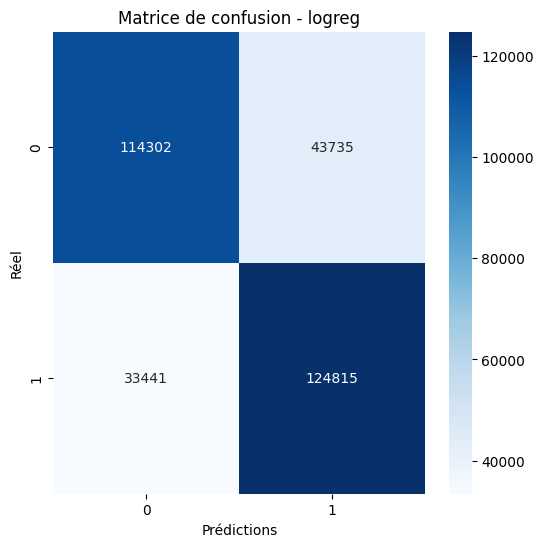


📊 Résultats pour : rf
              precision    recall  f1-score   support

           0       0.73      0.74      0.73    158037
           1       0.74      0.72      0.73    158256

    accuracy                           0.73    316293
   macro avg       0.73      0.73      0.73    316293
weighted avg       0.73      0.73      0.73    316293



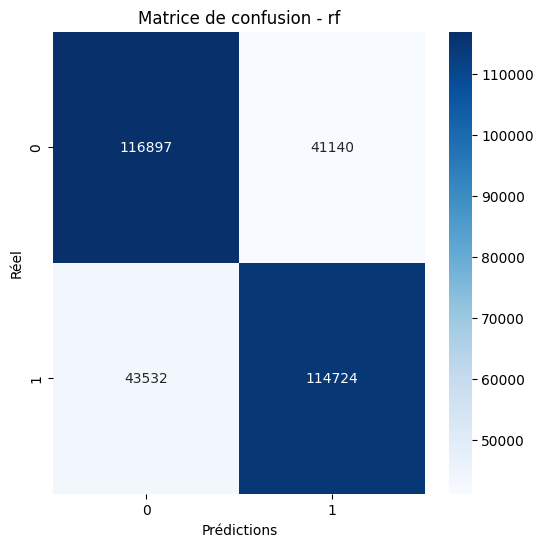

9885/9885 ━━━━━━━━━━━━━━━━━━━━ 8s 767us/step

📊 Résultats pour : lstm
              precision    recall  f1-score   support

           0       0.77      0.78      0.78    158037
           1       0.78      0.77      0.77    158256

    accuracy                           0.78    316293
   macro avg       0.78      0.78      0.78    316293
weighted avg       0.78      0.78      0.78    316293



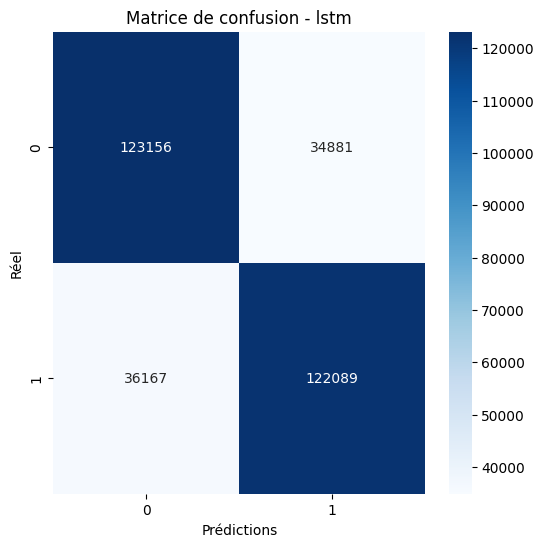


📊 Résultats pour : lgbm
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1505
           1       0.71      0.72      0.72      1495

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



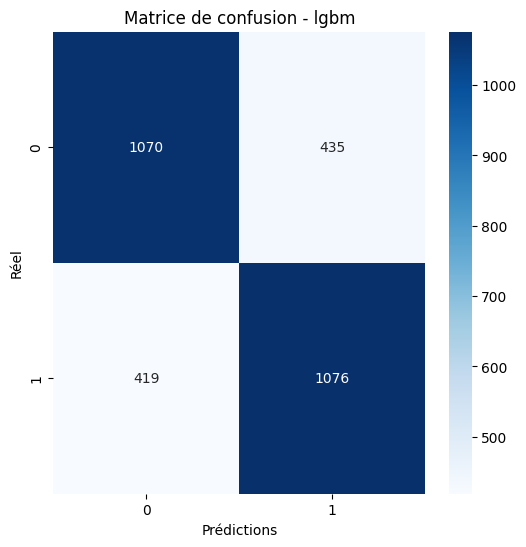


📊 Comparaison finale des modèles :


,Modèle,Accuracy,F1-score
0,logreg,0.7560,0.7638
1,rf,0.7323,0.7304
2,lstm,0.7754,0.7746
3,lgbm,0.7153,0.7159
4,DistilBERT fine-tuné,0.8423,0.8427


🏃 View run valuable-foal-494 at: http://127.0.0.1:5000/#/experiments/2/runs/9b1212a6c9ad453a9b3db026a11cf41b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
✅ Run terminé.


In [23]:
df_results = ev.get_all_model_scores(models_dict, datasets_dict)

# 9 - Tracking MLFlow

In [24]:
y_pred = log_reg_model.predict(X_tfidf_test)
with mlflow.start_run(run_name="Logistic Regression final metrics"):
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))

🏃 View run Logistic Regression final metrics at: http://127.0.0.1:5000/#/experiments/2/runs/e4ab79a61cc34e85b1c7d5c5bbc61d7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [25]:
if mlflow.active_run() is not None:
    mlflow.end_run()

In [26]:
with mlflow.start_run():
    # entraînement modèle, log params & metrics
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))

🏃 View run enchanting-steed-26 at: http://127.0.0.1:5000/#/experiments/2/runs/222a8edc21714aeaa02bf1a88a0d996d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# A désactiver en production

In [27]:
utils.launch_mlflow_ui()

🚀 MLFlow UI lancé sur http://127.0.0.1:5000


In [28]:
# mlflow.end_run()  # Pour stopper tout run en cours
